# Load dataset

In [2]:
from flwr_datasets.partitioner import IidPartitioner
from torch.utils.data import DataLoader
import datasets
import pandas as pd
import numpy as np
from PIL import Image
import torch


class ClinicPartitioner(IidPartitioner):
    """Partitioner for splitting MNIST into 5 centers."""

    def __init__(self):
        super().__init__(num_partitions=5)

    def load_partition(self, partition_id: int) -> datasets.Dataset:
        """
        Creates 5 partitions of the dataset:
            1. 0's and 1's
            2. 2's and 3's
            3. 4's and 5's
            4. 6's and 7's
            5. 8's and 9's
        """

        # Return the entire dataset if partition_id is -1
        if (partition_id == -1):
            return self.dataset

        df = pd.DataFrame(
            {
                "image": [np.array(img) for img in self.dataset["image"]],
                "label": self.dataset["label"],
            }
        )

        df1 = df[df["label"].isin([0, 1])]
        df2 = df[df["label"].isin([2, 3])]
        df3 = df[df["label"].isin([4, 5])]
        df4 = df[df["label"].isin([6, 7])]
        df5 = df[df["label"].isin([8, 9])]

        def convertPDtoDS(df):
            return datasets.Dataset.from_dict({
                "image": [Image.fromarray(np.array(img)) for img in df["image"]],
                "label": df["label"],
            })

        splitDataset = [
            convertPDtoDS(df1),
            convertPDtoDS(df2),
            convertPDtoDS(df3),
            convertPDtoDS(df4),
            convertPDtoDS(df5),
        ]

        return splitDataset[partition_id]


trainPartitioner = None
testPartitioner = None


def load_data(partition_id: int, split: int):
    """Load partition MNIST data."""
    # Only initialize `FederatedDataset` once
    global trainPartitioner, testPartitioner
    if trainPartitioner is None or testPartitioner is None:
        trainPartitioner = ClinicPartitioner()
        testPartitioner = ClinicPartitioner()
        ds = datasets.load_dataset(path="ylecun/mnist")
        ds = datasets.concatenate_datasets([ds["train"], ds["test"]])
        trainPartitioner.dataset = datasets.concatenate_datasets([ds.shard(5, i) for i in list(filter(lambda x: x != split, range(5)))])
        testPartitioner.dataset = ds.shard(5, split)
    partition_train = trainPartitioner.load_partition(partition_id)
    partition_test = testPartitioner.load_partition(partition_id)

    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["image"] = [(np.array(img, dtype=np.float32) / 256).flatten() for img in batch["image"]] # Transform images to float and normalize
        return batch


    partition_train = partition_train.with_transform(apply_transforms)
    partition_test = partition_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train, batch_size=32, shuffle=True)
    testloader = DataLoader(partition_test, batch_size=32)
    return trainloader, testloader



c:\Users\Bruger\Desktop\Bachelor-Project---Federated-Incremental-Learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get model

In [3]:
import torch.nn as nn
import torch.nn.functional as F


# Define autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 784),
            nn.ReLU(),
            nn.Sigmoid(),  # Use Sigmoid to ensure output is in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_embedding(self, x):
        """Get the embedding from the encoder."""
        return self.encoder(x)
    
# Define train function
def train(model, trainloader, device):
    model.train()
    total_loss = 0.0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    for data in trainloader:
        inputs = data["image"].to(device)
        inputs = inputs.view(inputs.size(0), -1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(trainloader)



# Train and test model

In [ ]:
net = Autoencoder()
i = 0
trainloader_global, testloader_global = load_data(-1, i)
# _, testloader01 = load_data(0, i)
# _, testloader23 = load_data(1, i)
# _, testloader45 = load_data(2, i)
# _, testloader67 = load_data(3, i)
# _, testloader89 = load_data(4, i)

# Get initial performance
epocs = 20
for i in range(epocs):
    print(f"Epoch {i+1}/{epocs}")
    # Train the model
    train_loss = train(net, trainloader_global, "cpu")
    print(f"Epoch {i+1}/{epocs}, train_loss: {train_loss:.4f}")


Epoch 1/50
Epoch 1/50, train_loss: 0.2234
Epoch 2/50
Epoch 2/50, train_loss: 0.2182
Epoch 3/50
Epoch 3/50, train_loss: 0.2153
Epoch 4/50
Epoch 4/50, train_loss: 0.2138
Epoch 5/50
Epoch 5/50, train_loss: 0.2133
Epoch 6/50
Epoch 6/50, train_loss: 0.2131
Epoch 7/50
Epoch 7/50, train_loss: 0.2131
Epoch 8/50
Epoch 8/50, train_loss: 0.2130
Epoch 9/50
Epoch 9/50, train_loss: 0.2130
Epoch 10/50
Epoch 10/50, train_loss: 0.2130
Epoch 11/50
Epoch 11/50, train_loss: 0.2130
Epoch 12/50
Epoch 12/50, train_loss: 0.2130
Epoch 13/50
Epoch 13/50, train_loss: 0.2129
Epoch 14/50
Epoch 14/50, train_loss: 0.2129
Epoch 15/50
Epoch 15/50, train_loss: 0.2129
Epoch 16/50
Epoch 16/50, train_loss: 0.2129
Epoch 17/50
Epoch 17/50, train_loss: 0.2129
Epoch 18/50
Epoch 18/50, train_loss: 0.2129
Epoch 19/50
Epoch 19/50, train_loss: 0.2129
Epoch 20/50
Epoch 20/50, train_loss: 0.2129
Epoch 21/50


KeyboardInterrupt: 

In [5]:
class ClinicPartitioner2(IidPartitioner):
    """Partitioner for splitting MNIST into 5 centers."""

    def __init__(self):
        super().__init__(num_partitions=10)

    def load_partition(self, partition_id: int) -> datasets.Dataset:
        """
        Creates 5 partitions of the dataset:
            1. 0's and 1's
            2. 2's and 3's
            3. 4's and 5's
            4. 6's and 7's
            5. 8's and 9's
        """

        # Return the entire dataset if partition_id is -1
        if (partition_id == -1):
            return self.dataset

        df = pd.DataFrame(
            {
                "image": [np.array(img) for img in self.dataset["image"]],
                "label": self.dataset["label"],
            }
        )

        df0 = df[df["label"].isin([0])]
        df1 = df[df["label"].isin([1])]
        df2 = df[df["label"].isin([2])]
        df3 = df[df["label"].isin([3])]
        df4 = df[df["label"].isin([4])]
        df5 = df[df["label"].isin([5])]
        df6 = df[df["label"].isin([6])]
        df7 = df[df["label"].isin([7])]
        df8 = df[df["label"].isin([8])]
        df9 = df[df["label"].isin([9])]

        def convertPDtoDS(df):
            return datasets.Dataset.from_dict({
                "image": [Image.fromarray(np.array(img)) for img in df["image"]],
                "label": df["label"],
            })

        splitDataset = [
            convertPDtoDS(df0),
            convertPDtoDS(df1),
            convertPDtoDS(df2),
            convertPDtoDS(df3),
            convertPDtoDS(df4),
            convertPDtoDS(df5),
            convertPDtoDS(df6),
            convertPDtoDS(df7),
            convertPDtoDS(df8),
            convertPDtoDS(df9),
        ]

        return splitDataset[partition_id]

trainPartitioner2 = None
testPartitioner2 = None

def load_data_2(partition_id: int, split: int):
    """Load partition MNIST data."""
    # Only initialize `FederatedDataset` once
    global trainPartitioner2, testPartitioner2
    if trainPartitioner2 is None or testPartitioner2 is None:
        trainPartitioner2 = ClinicPartitioner2()
        testPartitioner2 = ClinicPartitioner2()
        ds = datasets.load_dataset(path="ylecun/mnist")
        ds = datasets.concatenate_datasets([ds["train"], ds["test"]])
        trainPartitioner2.dataset = datasets.concatenate_datasets([ds.shard(5, i) for i in list(filter(lambda x: x != split, range(5)))])
        testPartitioner2.dataset = ds.shard(5, split)
    partition_train = trainPartitioner2.load_partition(partition_id)
    partition_test = testPartitioner2.load_partition(partition_id)

    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["image"] = [(np.array(img, dtype=np.float32) / 256).flatten() for img in batch["image"]] # Transform images to float and normalize
        return batch


    partition_train = partition_train.with_transform(apply_transforms)
    partition_test = partition_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train, batch_size=32, shuffle=True)
    testloader = DataLoader(partition_test, batch_size=32)
    return trainloader, testloader

In [6]:
def get_embeddings(net, loader):
    """Get embeddings for the dataset."""
    net.eval()
    embeddings = []
    with torch.no_grad():
        for data in loader:
            inputs = data["image"].to("cpu")
            inputs = inputs.view(inputs.size(0), -1)
            embedding = net.get_embedding(inputs)
            embeddings.append(embedding.cpu().numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

In [7]:
_, loader0 = load_data_2(0, 0)
_, loader1 = load_data_2(1, 0)
_, loader2 = load_data_2(2, 0)
_, loader3 = load_data_2(3, 0)

print("Loaded data")

nll1stoutput0 = get_embeddings(net, loader0)
nll1stoutput1 = get_embeddings(net, loader1)
nll1stoutput2 = get_embeddings(net, loader2)
nll1stoutput3 = get_embeddings(net, loader3)

Loaded data


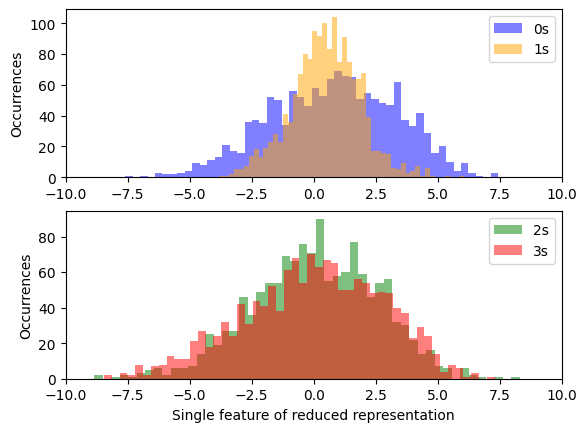

In [8]:
# Make histogram of nll1stoutput
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)

ax[0].hist(nll1stoutput0[:, 5], bins=50, alpha=0.5, label='0s', color='blue')
ax[0].hist(nll1stoutput1[:, 5], bins=50, alpha=0.5, label='1s', color='orange')
ax[1].hist(nll1stoutput2[:, 5], bins=50, alpha=0.5, label='2s', color='green')
ax[1].hist(nll1stoutput3[:, 5], bins=50, alpha=0.5, label='3s', color='red')
# Set common xlabel and ylabel for subplots
ax[1].set_xlabel('Single feature of reduced representation')
ax[0].set_ylabel('Occurrences')
ax[1].set_ylabel('Occurrences')

ax[0].set_xlim(-10, 10)
ax[1].set_xlim(-10, 10)
ax[0].legend()
ax[1].legend()


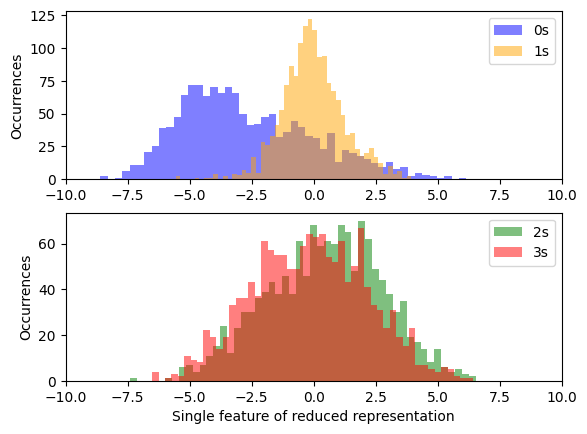

In [9]:
# Make histogram of nll1stoutput
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)

ax[0].hist(nll1stoutput0[:, 7], bins=50, alpha=0.5, label='0s', color='blue')
ax[0].hist(nll1stoutput1[:, 7], bins=50, alpha=0.5, label='1s', color='orange')
ax[1].hist(nll1stoutput2[:, 7], bins=50, alpha=0.5, label='2s', color='green')
ax[1].hist(nll1stoutput3[:, 7], bins=50, alpha=0.5, label='3s', color='red')
# Set common xlabel and ylabel for subplots
ax[1].set_xlabel('Single feature of reduced representation')
ax[0].set_ylabel('Occurrences')
ax[1].set_ylabel('Occurrences')

ax[0].set_xlim(-10, 10)
ax[1].set_xlim(-10, 10)
ax[0].legend()
ax[1].legend()


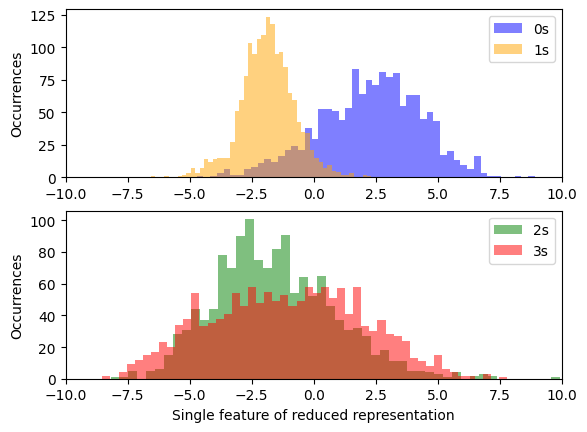

In [15]:
# Make histogram of nll1stoutput
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)

ax[0].hist(nll1stoutput0[:, 0], bins=50, alpha=0.5, label='0s', color='blue')
ax[0].hist(nll1stoutput1[:, 0], bins=50, alpha=0.5, label='1s', color='orange')
ax[1].hist(nll1stoutput2[:, 0], bins=50, alpha=0.5, label='2s', color='green')
ax[1].hist(nll1stoutput3[:, 0], bins=50, alpha=0.5, label='3s', color='red')
# Set common xlabel and ylabel for subplots
ax[1].set_xlabel('Single feature of reduced representation')
ax[0].set_ylabel('Occurrences')
ax[1].set_ylabel('Occurrences')

ax[0].set_xlim(-10, 10)
ax[1].set_xlim(-10, 10)
ax[0].legend()
ax[1].legend()

fig.savefig("MNISTDomainShiftAutoEncoder.svg", format='svg', bbox_inches='tight', dpi=300)